# Smile Classification :)

#### Mohammad Amin Kiani 4003613052
###### Uni of Isfahan - Iran
###### Deep Learning - Dr.Kiani 1404-1403

---------------------------------------------------------------------


## Requirements

#### Genki4K DataSet

In [ ]:
%ls
from google.colab import files
uploaded = files.upload()

import zipfile
import io

zf = zipfile.ZipFile(io.BytesIO(uploaded['kaggle-genki4k.zip']), "r")
zf.extractall()

sample_data/


Saving kaggle-genki4k.zip to kaggle-genki4k.zip


## All Libs

In [4]:
import numpy as np
import os
import cv2
# ------------------------------------------------------------------------
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import VGG16

from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import dlib
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau


# from google.colab import drive
# drive.mount('/content/drive')

## Face Detect

In [ ]:
with tf.device('/GPU:0'):

  # مسیر دیتاها
  data_dir = '/content/kaggle-genki4k'
  cropped_dir = '/content/crops'


  # تابع برش چهره‌ها از تصاویر
  # Cascade Classifier برای تشخیص چهره : کتابخانه
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

  # https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_eye.xml
  eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')


  # cropped_dir = '/content/crops'
  os.makedirs(cropped_dir, exist_ok=True)

  def crop_face(image_path, save_path, rect=None):
      image = cv2.imread(image_path)
      if image is None:
        print(f"Error loading image: {image_path}")
        return

      # تصویر را به سیاه سفید تبدیل که برای الگوریتم‌های تشخیص چهره است
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

      if rect is None:
        # اگر RECTANGLE مشخص نشده است، آن را پیدا می‌کنیم
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=3,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )

        if len(faces) == 0:

          print(f"No face detected in {image_path}")
          return

        # انتخاب اولین چهره
        rect = faces[0]

      (x, y, w, h) = rect
      face_crop = cv2.resize(image[y:y+h, x:x+w], (224, 224))
      cv2.imwrite(save_path, face_crop)


  # data_dir = '/content/kaggle-genki4k'
  # برش چهره‌ها و ذخیره‌سازی
  for label in ['smile', 'non_smile']:
    label_dir = os.path.join(data_dir, label)
    cropped_label_dir = os.path.join(cropped_dir, label)
    os.makedirs(cropped_label_dir, exist_ok=True)

    for img_name in os.listdir(label_dir):
      img_path = os.path.join(label_dir, img_name)
      save_path = os.path.join(cropped_label_dir, img_name)

      # RECTANGLE برای محدود کردن جستجوی چهره
      image = cv2.imread(img_path)
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      faces = face_cascade.detectMultiScale(
          gray,
          scaleFactor=1.012,   # کاهش دادم تا صورت های کوچک تر را هم در بر بگیرد.
          minNeighbors=1,
          minSize=(10, 10),
          flags=cv2.CASCADE_SCALE_IMAGE
      )

      if len(faces) > 0:
        rect = faces[0]  # انتخاب اولین چهره
        crop_face(img_path, save_path, rect)

      else:
        print(f"No face detected in {img_path}")


No face detected in /content/kaggle-genki4k/smile/file0335.jpg
No face detected in /content/kaggle-genki4k/smile/file1924.jpg
No face detected in /content/kaggle-genki4k/smile/file0740.jpg
No face detected in /content/kaggle-genki4k/non_smile/file3431.jpg


## Download Crops to See

In [ ]:
# files.download(cropped_dir)

import shutil

# Create a zip file of the crops directory
shutil.make_archive('/content/crops', 'zip', '/content/crops')

files.download('/content/crops.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
%ls
from google.colab import files
uploaded = files.upload()

import zipfile
import io

zf = zipfile.ZipFile(io.BytesIO(uploaded['fine_crops.zip']), "r")
zf.extractall()

cropped_dir = '/content/fine_crops'


sample_data/


Saving fine_crops.zip to fine_crops.zip


## Make & Compile AminNet_Model

In [5]:

# # this code helps to read the images faster
# AUTOTUNE = tf.data.AUTOTUNE
# train_generator = train_generator.prefetch(buffer_size=AUTOTUNE)
# validation_generator = validation_generator.prefetch(buffer_size=AUTOTUNE)


# from tensorflow.keras.applications import MobileNetV2
# # ترنسفر لرن بدون هد و فقط بک بون و تعیین اندازه ورودی
# # بارگذاری مدل MobileNet بدون لایه‌های بالایی و تعیین اندازه ورودی
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


IMAGE_SHAPE = [224, 224]
batch_size=10
epochs = 12

base_model = VGG16(input_shape = (224,224,3), weights = 'imagenet', include_top = False)

# from tensorflow.keras.applications import EfficientNetB7
# # Load EfficientNet-B7 model without top layers
# base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers  وزن‌ها در حین آموزش تغییر نمی‌کنند. برای جلوگیری از افت کیفیت ویژگی‌های استخراج شده،
# base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(2, activation='softmax')(x)  # number ofclasses = 2

model = models.Model(inputs=base_model.input, outputs=x)

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#-----------------------------------------------------------------------------------------------------


# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# prediction_layer = tf.keras.layers.Dense(1)

# inputs = tf.keras.Input(shape=(224, 224, 3))
# x = preprocess_input(inputs)
# x = base_model(x, training=False)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.001
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
with tf.device('/GPU:0'):

  #   # Prepare dataset
  # train_dataset = image_dataset_from_directory(
  #     cropped_dir,
  #     shuffle=True,
  #     seed=SEED,
  #     image_size=IMAGE_SIZE,
  #     batch_size=BATCH_SIZE,
  #     validation_split=VALIDATION_SPLIT,
  #     subset='training'
  # )

  # validation_dataset = image_dataset_from_directory(
  #     cropped_dir,
  #     shuffle=False,
  #     seed=SEED,
  #     image_size=IMAGE_SIZE,
  #     batch_size=BATCH_SIZE,
  #     validation_split=VALIDATION_SPLIT,
  #     subset='validation'
  # )

  # # Normalize pixel values
  # def normalize_images(image, label):
  #     image = tf.cast(image, tf.float32) / 255.
  #     return image, label

  # train_dataset = train_dataset.map(normalize_images)
  # validation_dataset = validation_dataset.map(normalize_images)

  # # Create data loaders
  # train_loader = tf.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, seed=SEED)
  # validation_loader = tf.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, seed=SEED)

  # # Training
  # history = model.fit(
  #     train_loader,
  #     validation_data=validation_loader,
  #     epochs=EPOCHS,
  #     callbacks=[early_stopping, reduce_lr]
  # )

  # print(model.predict(train_loader))

  #----------------------------------------------------------------------------

  # آماده‌سازی داده‌ها با ImageDataGenerator
  # augmentation
  datagen = ImageDataGenerator(
      rescale=1./255,  #  0 255 ==> 0  1
      rotation_range=20,  # تصاویر تا ۲۰ درجه چرخش
      width_shift_range=0.2,  # تصاویر به اندازه ۲۰ درصد از عرض یا ارتفاع خود جابجا
      height_shift_range=0.2,
      shear_range=0.2,  # برش دهی  تا ۲۰ درصد
      zoom_range=0.2,   # زوم بر روی تصاویر تا ۲۰ درصد.
      horizontal_flip=True,  #تصاویر می‌توانند به صورت افقی
      fill_mode='nearest',   # پر کردن پیکسل‌های جدید، نزدیکترین مقدار
      validation_split=0.2)  # 20 درصد داده‌ها برای تست

  train_generator = datagen.flow_from_directory(
      directory=cropped_dir,
      target_size=(224, 224),
      batch_size=10,
      class_mode='categorical',
      subset='training',
      shuffle=True                # تصادفی کردن تصاویر برای جلوگیری از دسترسی‌های بلوکی به داده‌ها
  )

  validation_generator = datagen.flow_from_directory(
      directory=cropped_dir,
      target_size=(224, 224),
      batch_size=10,
      class_mode='categorical',
      subset='validation',
      shuffle=False
  )

#   #------------------------------------------------------------------------

#   # استخراج ویژگی‌ها
#   train_features = model.predict(train_generator)
#   train_labels = train_generator.classes

#   validation_features = model.predict(validation_generator)
#   validation_labels = validation_generator.classes

#   #------------------------------------------------------------------------

  early_stopping = EarlyStopping(monitor='val_loss',   #معیار نظارت بر بهبود مدل.
                                #  min_delta=0.03, # minimium amount of change to count as an improvement
                                patience=2,  # اگر تغییر در معیار بیشتر از ۲ دوره مشاهده نشود، آموزش متوقف می‌شود
                                restore_best_weights=True)  # وزن بهترین مدل ذخیره شده بازگردانده می‌شود.

  reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,  #  اگر بهبودی نباشد، نرخ یادگیری به ۲۰ درصد کاهش
                                patience=2,
                                min_lr=1e-6)  # حداقل نرخ

  history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      verbose=1, # نمایش خروجی بیشتر
      # verbose=0: Minimal output. Only shows epoch number and total time.
      #verbose=1: Moderate output. Shows epoch number, validation loss, and accuracy.
      #verbose=2: Detailed output. Shows batch size, iteration number, loss, accuracy, etc.

      callbacks=[early_stopping, reduce_lr]   # استراتژی‌های حضوری برای شرایط خاص
  )

  #برچسب‌های کلاس‌ها و تعداد نمونه‌های موجود در ژنراتور آموزشی
  print(train_generator.classes)
  print(train_generator.samples)

# #-----------------------------------------------------------------------------------------------------

# # model = models.Sequential([
# #     # base_model,
# #     # layers.GlobalAveragePooling2D(),
# #     layers.Flatten(input_shape=train_features.shape[1:]),  # 1D : vector
# #     layers.Dense(128, activation='relu'),
# #     layers.Dropout(0.2),
# #     layers.Dense(1, activation='sigmoid')
# # ])

# #-----------------------------------------------------------------------------------------------------


# # from tensorflow.keras import layers, models
# # from tensorflow.keras.models import Model
# # from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
# # from tensorflow.keras.optimizers import Adam
# # def create_model():
# #     # base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# #     x = base_model.output
# #     x = GlobalAveragePooling2D()(x)
# #     x = Dense(1024, activation='relu')(x)
# #     predictions = Dense(1, activation='sigmoid')(x)

# #     model = Model(inputs=base_model.input, outputs=predictions)

# #     return model

# # model = create_model()

# # # کامپایل مدل
# # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Found 3100 images belonging to 2 classes.
Found 774 images belonging to 2 classes.
Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


310/310 ━━━━━━━━━━━━━━━━━━━━ 68s 185ms/step - accuracy: 0.6356 - loss: 0.8231 - val_accuracy: 0.7855 - val_loss: 0.4260 - learning_rate: 0.0010
Epoch 2/12
310/310 ━━━━━━━━━━━━━━━━━━━━ 53s 168ms/step - accuracy: 0.7668 - loss: 0.4900 - val_accuracy: 0.7132 - val_loss: 0.5202 - learning_rate: 0.0010
Epoch 3/12
310/310 ━━━━━━━━━━━━━━━━━━━━ 53s 168ms/step - accuracy: 0.7832 - loss: 0.4477 - val_accuracy: 0.7855 - val_loss: 0.4396 - learning_rate: 0.0010
[0 0 0 ... 1 1 1]
3100


In [7]:

Y_pred = model.predict(validation_generator, validation_generator.samples / batch_size)

# axix ==> کدام محور (یا ابعاد) آرایه بررسی شود تا بزرگ‌ترین مقدار گرفته شود
# axis=0: بالاترین مقدار در هر ستون (کلاس‌ها)
# axis=1: بالاترین مقدار در هر ردیف (نمونه‌ها)
val_preds = np.argmax(Y_pred, axis=1) #  تعیین کلاس‌های پیش‌بینی شده

import sklearn.metrics as metrics
val_trues =validation_generator.classes  #برچسب‌ها برای مقایسه با پیش‌بینی‌ها

from sklearn.metrics import classification_report
print(classification_report(val_trues, val_preds))  #گزارشی شامل دقت، فراخوانی ، و متوسط دقت

# # آموزش مدل با داده‌های آموزشی و تست روی داده‌های اعتبارسنجی

# history = model.fit(train_features,
#                     train_labels,
#                     batch_size=32,
#                     epochs=initial_epochs,
#                     validation_data=(validation_features, validation_labels),
#                     callbacks=[early_stopping])


# # ارزیابی مدل روی داده‌های اعتبارسنجی
# loss, accuracy = model.evaluate(validation_features, validation_labels)

# print(f"Validation Accuracy: {accuracy * 100:.2f}%")
# print(f"Validation Loss: {loss:.4f}")

# test_loss, test_accuracy = model.evaluate(test_datagen.flow_from_directory(
#     'crops',
#     target_size=(224, 224),
#     class_mode='binary',
#     batch_size=32
# ))

# print(f'Test accuracy: {test_accuracy:.2f}')

# ذخیره مدل
model.save('AminNet_Model_SmileDetector.h5')

files.download('AminNet_Model_SmileDetector.h5')
# قابلیت ذخیره‌سازی داده‌های بزرگ با سرعت بالا
# سازگاری با اکثر کتابخانه‌های عصبی
# امکان ذخیره‌سازی وزن‌ها، ساختار شبکه و متغیرهای حالت


78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step


              precision    recall  f1-score   support

           0       0.81      0.67      0.73       355
           1       0.75      0.86      0.81       419

    accuracy                           0.77       774
   macro avg       0.78      0.77      0.77       774
weighted avg       0.78      0.77      0.77       774



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Summary

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 24,374,024 (92.98 MB)

 Trainable params: 3,219,778 (12.28 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 6,439,558 (24.56 MB)

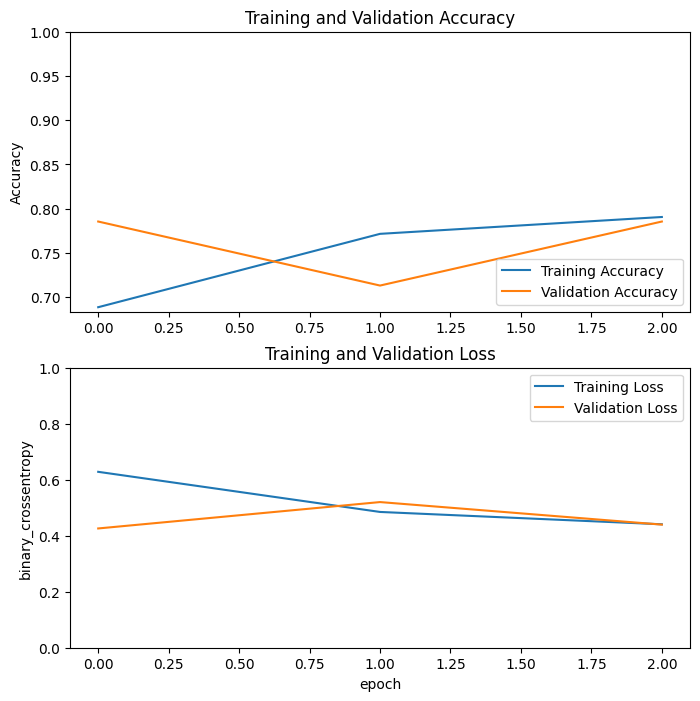

Epoch 3/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


310/310 ━━━━━━━━━━━━━━━━━━━━ 56s 173ms/step - accuracy: 0.7751 - loss: 0.4838 - val_accuracy: 0.8101 - val_loss: 0.4369
Epoch 4/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 80s 171ms/step - accuracy: 0.7960 - loss: 0.4360 - val_accuracy: 0.8049 - val_loss: 0.4206
Epoch 5/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 82s 170ms/step - accuracy: 0.8024 - loss: 0.4224 - val_accuracy: 0.8088 - val_loss: 0.4405
Epoch 6/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step - accuracy: 0.8101 - loss: 0.4312 - val_accuracy: 0.7661 - val_loss: 0.4702
Epoch 7/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 54s 171ms/step - accuracy: 0.7966 - loss: 0.4233 - val_accuracy: 0.8101 - val_loss: 0.4160
Epoch 8/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 54s 171ms/step - accuracy: 0.8179 - loss: 0.3993 - val_accuracy: 0.7726 - val_loss: 0.4370
Epoch 9/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 81s 169ms/step - accuracy: 0.8245 - loss: 0.3827 - val_accuracy: 0.8178 - val_loss: 0.4035
Epoch 10/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 82s 170ms/step - accuracy: 0.8380 - loss: 0.3849 - va

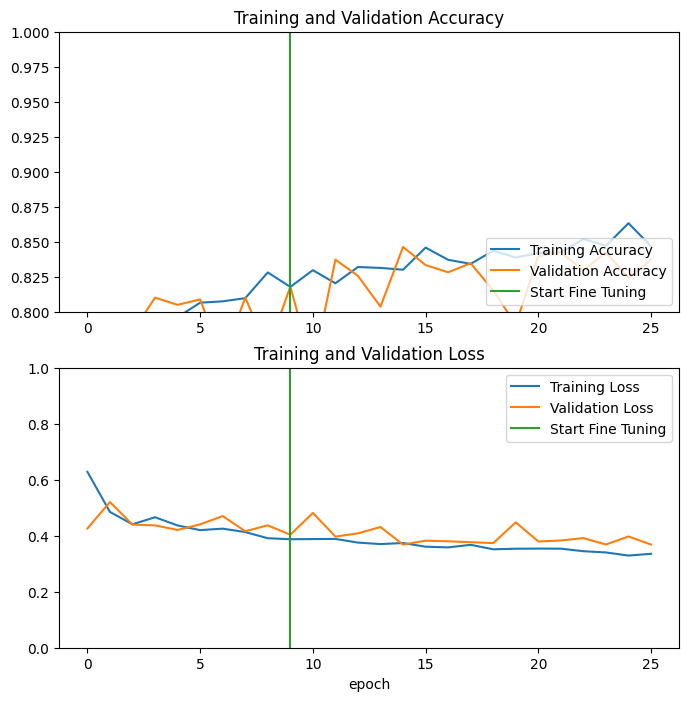

In [8]:
base_model.summary()
model.summary()


import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('binary_crossentropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# -------------------------------------------------------------------------- tune
base_model.trainable = True  # می‌توانند وزن‌های خود را در طول فرایند آموزش به‌روزرسانی کنند.
fine_tune_at = 100

#(زیر ۱۰۰)، وزن‌ها قابل آموزش نباشند. این به ما کمک می‌کند تا فقط لایه‌های بالایی مدل در طول فرآیند Fine-Tuning آموزش ببینند.
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001/10),
              metrics=['accuracy'])

initial_epochs = 10
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator)


acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Final Result **

In [9]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

model.save('AminNet_Model.h5')

files.download('AminNet_Model.h5')

# from google.colab import drive
# drive.mount('/content')
# # Copy the file to Google Drive
# !cp 'AminNet_Model_SmileDetector.h5' '/content/drive/MyDrive/'

78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.8658 - loss: 0.3499


Validation Accuracy: 83.33%
Validation Loss: 0.3757


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# My Video

In [10]:
# --------------------------------------- model
from google.colab import files
uploaded = files.upload()

# --------------------------------------- video
from google.colab import files
uploaded = files.upload()

Saving 4003613052_MohammadAminKiani.mp4 to 4003613052_MohammadAminKiani.mp4


In [11]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the trained classifier model
model = load_model('AminNet_Model.h5')

# Load the feature extractor model (VGG16 without the top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# directory to store face crops
if not os.path.exists('Myface_crops'):
    os.makedirs('Myface_crops')

# predict smile or not on a each frame and draw a rectangle
def predict_and_draw(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)   # Convert the image to grayscale for better detection
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    for (x, y, w, h) in faces:
        # Crop and resize face to match input size 224*224
        face_crop = cv2.resize(frame[y:y+h, x:x+w], (224, 224))
        # Expand dimensions to match Keras input requirements
        face_crop_preprocessed = preprocess_input(np.expand_dims(face_crop, axis=0))  # Preprocess the face crop

        # Save the face crop
        cv2.imwrite(f'/content/Myface_crops/face_{x}_{y}.jpg', face_crop)

        # Predict using the classifier model directly on the raw face crop
        prediction = model.predict(face_crop_preprocessed)

        # Draw rectangle based on prediction
        if prediction[0][0] > 0.5:  # treshold for 2 class
            color = (0, 0, 255)  # Red for non-smile
            label = "Non_Smile :( "
        else:
            color = (0, 255, 0)  # Green for smile
            label = "Smile :) "

        # Draw rectangle and label around the face
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2) #2: ضخامت خط مستطیل
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)  # Display the label متن کمی بالاتر از بالای مستطیل

# process video frame by frame and save the output video
def process_video(video_path, output_path):
    cap = cv2.VideoCapture(video_path)  # Open the video

    # opened successfully?
    if not cap.isOpened():
        print("Error opening video file")
        return

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS)) #تعداد فریم‌هایی که در هر ثانیه نمایش داده

    # (Codec) در ویدیو به برنامه یا الگوریتمی اطلاق می‌شود که برای فشرده‌سازی و از بین بردن اطلاعات اضافی ویدیو
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' به معنای استفاده از کدک MP4
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()   # ret : آیا فریم با موفقیت خوانده شده یا خیر

        # ret ==> true   : still has frame

        if not ret:   #  ret ==> False  (یعنی نتوانسته‌ایم فریم را بخوانیم)
            break

        # Predict smile and draw rectangle
        predict_and_draw(frame)

        # Write the frame to the output video
        out.write(frame)

    # Release video capture and writer منابع مربوط به ویدیو را آزاد می‌کنند، تا از نشت حافظه جلوگیری شود.
    cap.release()
    out.release()
    print("Processing completed. SmileDetection Video saved as:", output_path)


# ---------------------------------------------------- predict video by model:

process_video('/content/4003613052_MohammadAminKiani.mp4', '/content/OutPut_SmileDetectionVideo.mp4')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━

Download Pics of me to see each frame & result predict

In [12]:

import shutil

# Create a zip file of the crops directory
shutil.make_archive('/content/Myface_crops', 'zip', '/content/Myface_crops')

files.download('/content/Myface_crops.zip')

files.download('/content/OutPut_SmileDetectionVideo.mp4')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# Smile Detection with Webcam/Video

from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Define video capture
cap = cv2.VideoCapture(0) # 0 for webcam, or specify video file path

# Load the trained model
model = load_model('AminNet_Model.h5')

# Function for smile detection on a frame
def detect_smile(frame):
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.012, 3)
  for (x, y, w, h) in faces:

    face = frame[y:y + h, x:x + w]

    face = cv2.resize(face, (224, 224))
    # normal_face = face / 255.0
    # reshape_face = np.reshape(normal_face, (1, 224, 224, 3))
    face_input = preprocess_input(np.expand_dims(face, axis=0))

    prediction = model.predict(face_input)

    if prediction[0][0] > 0.5:
      cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
      cv2.putText(frame, 'Smile :)', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    else:
      cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)
      cv2.putText(frame, 'Non_Smile :(', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

  return frame

# Process video frames
while True:
  ret, frame = cap.read()
  if not ret:
    break
  frame = detect_smile(frame)
  cv2.imshow('Smile Detection', frame)
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

# Release resources
cap.release()
cv2.destroyAllWindows()